                       date   PopulationName          lat           lon  \
1      2016-04-20T00:00:00Z  Prochlorococcus          NaN           NaN   
2      2016-04-20T00:00:00Z    Synechococcus          NaN           NaN   
3      2016-04-20T00:00:00Z      non_pro_syn          NaN           NaN   
4      2016-04-20T00:00:00Z      non_pro_syn          NaN           NaN   
5      2016-04-20T01:00:00Z  Prochlorococcus          NaN           NaN   
...                     ...              ...          ...           ...   
12183  2021-12-30T00:00:00Z      non_pro_syn  32.67349333  -117.5453421   
12184  2021-12-30T01:00:00Z  Prochlorococcus  32.68209958  -117.6603213   
12185  2021-12-30T01:00:00Z    Synechococcus  32.68209958  -117.6603213   
12186  2021-12-30T01:00:00Z      non_pro_syn  32.68209958  -117.6603213   
12187  2021-12-30T01:00:00Z      non_pro_syn  32.68209958  -117.6603213   

      cell_abundance      biomass   cellquotas cell_diameter        salin  \
1         253.186148  

/var/folders/w6/gkpzzsjx0n101092kzm2dnh00000gn/T/ipykernel_90949/617929011.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


<Figure size 640x480 with 0 Axes>

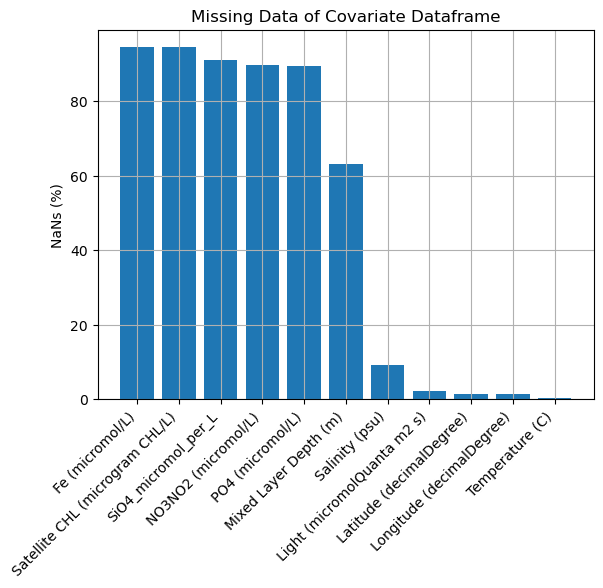

/var/folders/w6/gkpzzsjx0n101092kzm2dnh00000gn/T/ipykernel_90949/1463451283.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covari['PopulationName'] = covari['PopulationName'].replace(


No NaNs found, Yay!


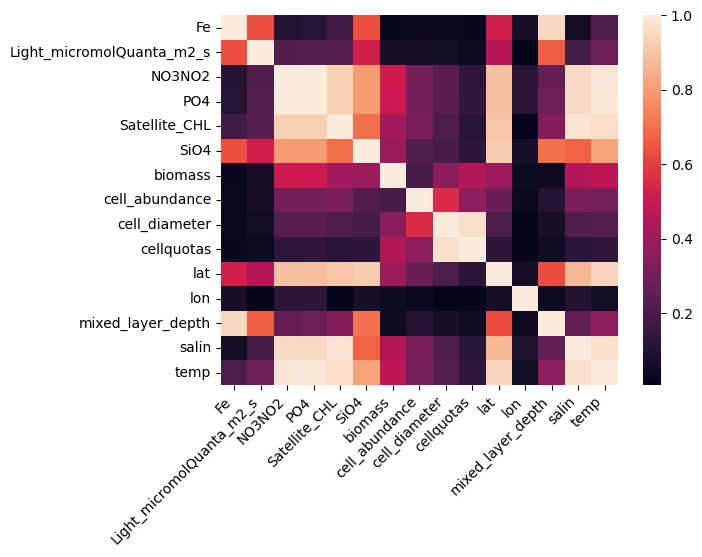

biomass  PO4              0.503028
PO4      biomass          0.503028
NO3NO2   biomass          0.504095
biomass  NO3NO2           0.504095
Fe       lat              0.520947
                            ...   
salin    Satellite_CHL    0.977863
temp     PO4              0.982861
PO4      temp             0.982861
temp     NO3NO2           0.984894
NO3NO2   temp             0.984894
Length: 64, dtype: float64


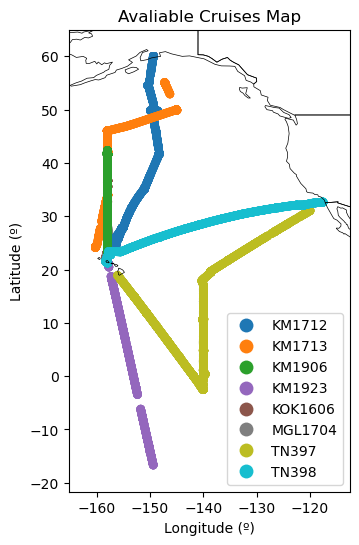

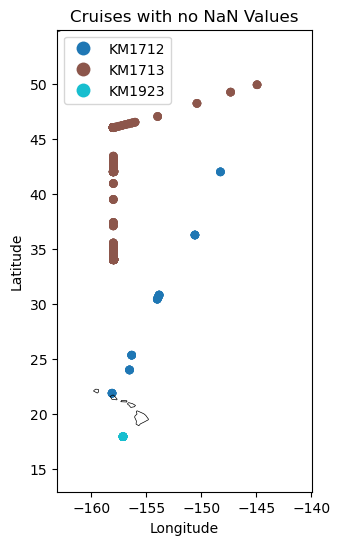

In [11]:
%run 03_data-QAQC.ipynb

# Developing a Random Forest Regressor for Each Population to Predict Biomass (pgC per L)

## Functions:

In [12]:
#function to make numpy array
def to_np(pop_feat):
    pop_feat = np.array(pop_feat)
    return pop_feat



## Seperating dataframes for individual populations

In [13]:
covari.head(3)

date   PopulationName        lat        lon  \
2849 2017-08-05 02:00:00+00:00  Prochlorococcus  21.869125 -158.11889   
2850 2017-08-05 02:00:00+00:00    Synechococcus  21.869125 -158.11889   
2851 2017-08-05 02:00:00+00:00      non_pro_syn  21.869125 -158.11889   

      cell_abundance   biomass  cellquotas  cell_diameter      salin  \
2849      211.519050  8.967613    0.042396        0.61338  35.029785   
2850        3.172882  2.320473    0.731346        1.84974  35.029785   
2851        1.978374  7.015652    3.546171        3.41083  35.029785   

          temp cruisename  Light_micromolQuanta_m2_s       SiO4    NO3NO2  \
2849  27.79885     KM1712                 473.451935  11.331458  0.000002   
2850  27.79885     KM1712                 473.451935  11.331458  0.000002   
2851  27.79885     KM1712                 473.451935  11.331458  0.000002   

           PO4        Fe  Satellite_CHL  mixed_layer_depth  
2849  0.328541  0.000067       0.039618          40.304435  
2850  0.328541  0.000067       0.039618          40.304435  
2851  0.328541  0.000067       0.039618          40.304435

In [18]:
pro_covari = covari[covari.PopulationName == 'Prochlorococcus']
syn_covari = covari[covari.PopulationName == 'Synechococcus']
non_covari = covari[covari.PopulationName == 'nanoeukaryotes (2-5µm)']


pop_covari_list = [pro_covari, syn_covari, non_covari]
# creating the labels for all of the populations for biomass (using numpy array so we can predict on them)

label_pro = np.array(pro_covari.biomass)
label_syn = np.array(syn_covari.biomass)
label_non = np.array(non_covari.biomass)

# Creating the features for all of the populations

#these are the dropped features
droped_features = ['date','PopulationName','cell_abundance',
                   'biomass', 'cell_abundance',
                  'cell_diameter', 'cruisename', 'Light_micromolQuanta_m2_s',
                   'cellquotas', 'mixed_layer_depth']

features_pro = pro_covari.drop(droped_features, axis = 1)
features_syn = syn_covari.drop(droped_features, axis = 1)
features_non = non_covari.drop(droped_features, axis = 1)


# Saving feature names for later use (doesn't matter which dataframe we use since they all have same column names)
feature_list = list(features_pro.columns)
# Convert to numpy array
pop_features = [features_pro,features_syn,features_non]


features_pro = to_np(features_pro)
features_syn = to_np(features_syn)
features_nano = to_np(features_non)


In [19]:
#loading packages for random forest modeling

from sklearn.model_selection import train_test_split
import joblib

## RF Regressor for Prochlorococcus

In [35]:
# Using Skicit-learn to split data into training and testing sets
# Split the data into training and testing sets"
train_features, test_features, train_labels, test_labels = train_test_split(features_pro, label_pro, test_size = 0.25, random_state = 42)

In [36]:
# Looking at the shape of the features and labels to see if they match up
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (44, 9)
Training Labels Shape: (44,)
Testing Features Shape: (15, 9)
Testing Labels Shape: (15,)


In [37]:
# We are using a regressor RF model because we are predicting on continous values
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 100 decision trees
rf_pro= RandomForestRegressor(n_estimators = 150, random_state = 42)
# Use the Training data to build the model
rf_pro.fit(train_features, train_labels)
#saving the model
joblib.dump(rf_pro, "/Users/cristianswift/Desktop/Spring-Quarter-2022-2023/SeniorThesis/RF_models/random_forest_pro.joblib")

['/Users/cristianswift/Desktop/Spring-Quarter-2022-2023/SeniorThesis/RF_models/random_forest_pro.joblib']

### Predicting and Testing for Prochlorococus

In [38]:
# Use the forest's predict method on the test data
predictions = rf_pro.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test_labels, predictions)
print('Mean Absolute Error:', round(mae, 2), 'pgC per L.')

Mean Absolute Error: 0.52 pgC per L.


In [39]:
# Get numerical feature importances
importances = list(rf_pro.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

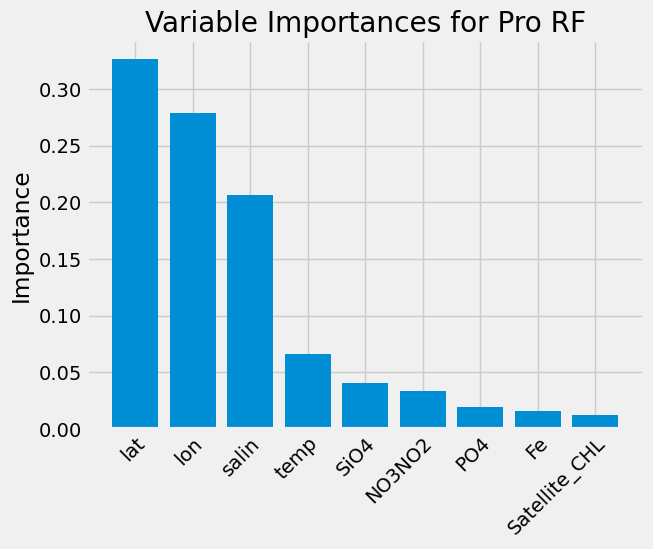

In [40]:
pro_feature_importance = pd.DataFrame(rf_pro.feature_importances_, index=feature_list).sort_values(by=0, ascending=False)

# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# Make a bar chart
plt.bar(x=pro_feature_importance.index,height=pro_feature_importance[0], orientation = 'vertical')
# Tick labels for x axis
plt.xticks(pro_feature_importance.index, feature_list, rotation=45, ha='right', rotation_mode='anchor')

# Axis labels and title
plt.ylabel('Importance'); plt.title('Variable Importances for Pro RF');

In [41]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 92.44 %.


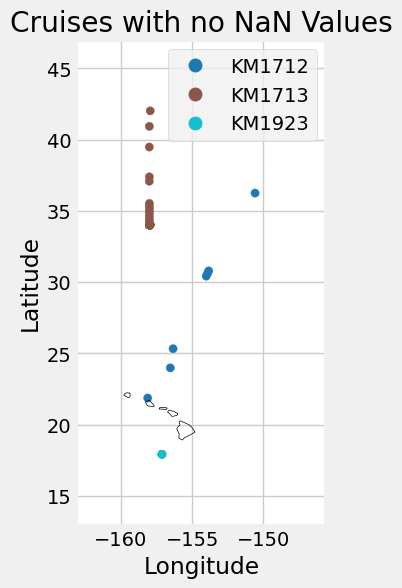

In [42]:
cruise_tract(pro_covari)

(0.0, 9.70520555395)

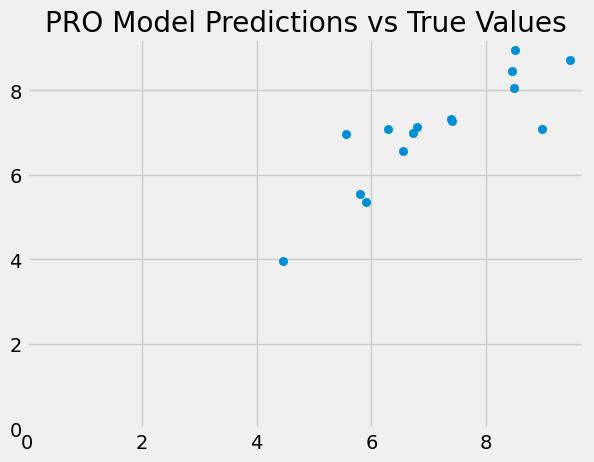

In [43]:
fig, ax = plt.subplots()
ax.scatter(test_labels, predictions)
ax.set_title('PRO Model Predictions vs True Values')
ax.set_ylim(ymin=0)
ax.set_xlim(xmin=0)


# run the model on each individual populaton - see which does best
#put zero values when 

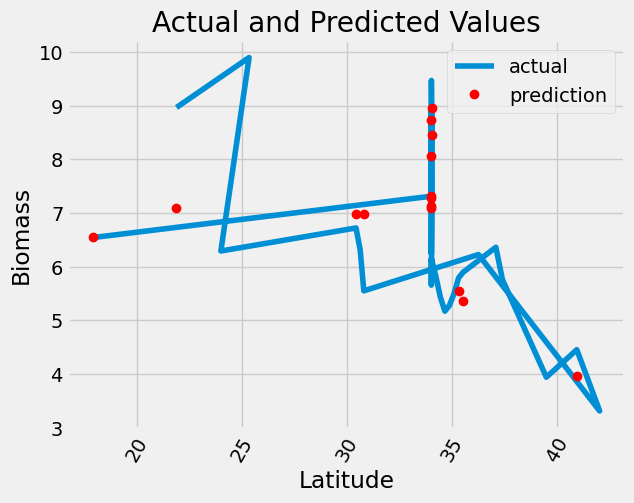

In [44]:
# latitudes of training values
lat = features_pro[:, feature_list.index('lat')]
# Dataframe with true values and dates
true_data = pd.DataFrame(data = {'lat': lat, 'actual': label_pro})
# latitudes of predictions
test_lats = test_features[:, feature_list.index('lat')]
# Dataframe with predictions and dates
predictions_data = pd.DataFrame(data = {'lat': test_lats, 'prediction': predictions})


# Plot the actual values
plt.plot(true_data['lat'], true_data['actual'], '-', label = 'actual')
# Plot the predicted values
plt.plot(predictions_data['lat'], predictions_data['prediction'], 'ro', label = 'prediction')
plt.xticks(rotation = 60); 
plt.legend()
# Graph labels
plt.xlabel('Latitude'); plt.ylabel('Biomass'); plt.title('Actual and Predicted Values');


## RF Regressor for Synechococcus

In [101]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets"
train_features, test_features, train_labels, test_labels = train_test_split(features_syn, label_syn, test_size = 0.25, random_state = 42)

In [102]:
# Looking at the shape of the features and labels to see if they match up
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (105, 9)
Training Labels Shape: (105,)
Testing Features Shape: (35, 9)
Testing Labels Shape: (35,)


In [103]:
# We are using a regressor RF model because we are predicting on continous values
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 100 decision trees
rf_syn = RandomForestRegressor(n_estimators = 10, random_state = 42)
# Use the Training data to build the model
rf_syn.fit(train_features, train_labels);
#saving the model
joblib.dump(rf_syn, "/Users/cristianswift/Desktop/Spring-Quarter-2022-2023/SeniorThesis/RF_models/random_forest_syn.joblib")

['/Users/cristianswift/Desktop/Spring-Quarter-2022-2023/SeniorThesis/RF_models/random_forest_syn.joblib']

In [104]:
# Use the forest's predict method on the test data
predictions = rf_syn.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test_labels, predictions)
print('Mean Absolute Error:', round(mae, 2), 'pgC per L.')

Mean Absolute Error: 0.14 pgC per L.


In [105]:
# Get numerical feature importances
importances = list(rf_syn.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

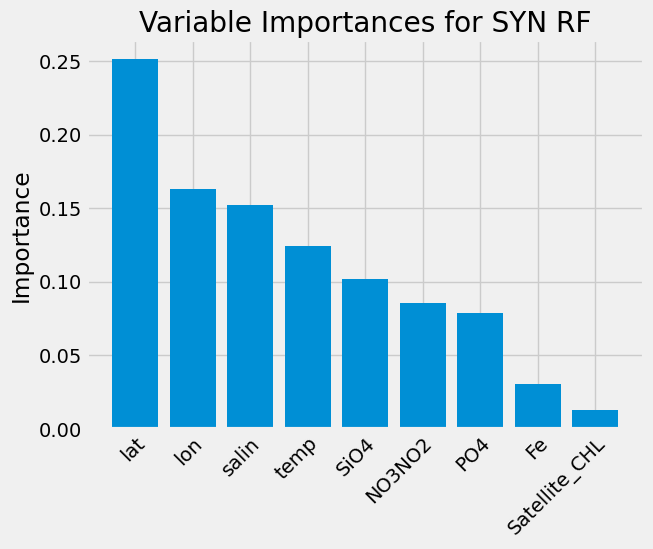

In [106]:
pro_feature_importance = pd.DataFrame(rf_syn.feature_importances_, index=feature_list).sort_values(by=0, ascending=False)

# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# Make a bar chart
plt.bar(x=pro_feature_importance.index,height=pro_feature_importance[0], orientation = 'vertical')
# Tick labels for x axis
plt.xticks(pro_feature_importance.index, feature_list, rotation=45, ha='right', rotation_mode='anchor')

# Axis labels and title
plt.ylabel('Importance'); plt.title('Variable Importances for SYN RF');

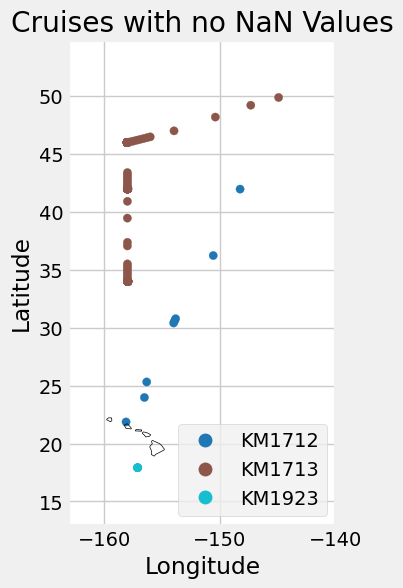

In [107]:
cruise_tract(syn_covari)

In [108]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 92.33 %.


(0.0, 3.9172343378)

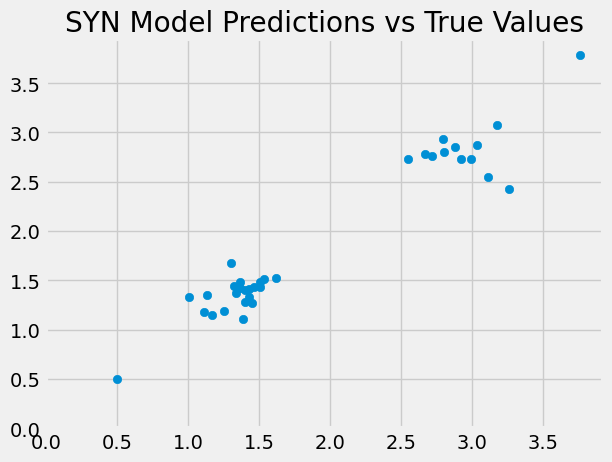

In [109]:
fig, ax = plt.subplots()
ax.scatter(test_labels, predictions)
ax.set_title('SYN Model Predictions vs True Values')
ax.set_ylim(ymin=0)
ax.set_xlim(xmin=0)


# run the model on each individual populaton - see which does best
#put zero values when 

## RF Regressor for PICO

In [ ]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets"
train_features, test_features, train_labels, test_labels = train_test_split(features_pico, label_pico, test_size = 0.25, random_state = 42)

In [ ]:
# Looking at the shape of the features and labels to see if they match up
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

In [ ]:
# We are using a regressor RF model because we are predicting on continous values
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 100 decision trees
rf_pico = RandomForestRegressor(n_estimators = 10, random_state = 42)
# Use the Training data to build the model
rf_pico.fit(train_features, train_labels);
joblib.dump(rf_pico, "/Users/cristianswift/Desktop/Spring-Quarter-2022-2023/SeniorThesis/RF_models/random_forest_pico.joblib")

In [ ]:
# Use the forest's predict method on the test data
predictions = rf_pico.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test_labels, predictions)
print('Mean Absolute Error:', round(mae, 2), 'pgC per L.')

In [ ]:
# Get numerical feature importances
importances = list(rf_pico.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

In [ ]:
pico_feature_importance = pd.DataFrame(rf_pico.feature_importances_, index=feature_list).sort_values(by=0, ascending=False)

# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# Make a bar chart
plt.bar(x=pico_feature_importance.index,height=pico_feature_importance[0], orientation = 'vertical')
# Tick labels for x axis
plt.xticks(pico_feature_importance.index, feature_list, rotation=45, ha='right', rotation_mode='anchor')

# Axis labels and title
plt.ylabel('Importance'); plt.title('Variable Importances for PICO RF');

In [ ]:
cruise_tract(pico_covari)

In [ ]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

In [ ]:
fig, ax = plt.subplots()
ax.scatter(test_labels, predictions)
ax.set_title('PICO Model Predictions vs True Values')
ax.set_ylim(ymin=0)
ax.set_xlim(xmin=0)


# run the model on each individual populaton - see which does best
#put zero values when 

## RF Regressor for Nano

In [ ]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets"
train_features, test_features, train_labels, test_labels = train_test_split(features_nano, label_nano, test_size = 0.25, random_state = 42)

In [ ]:
# Looking at the shape of the features and labels to see if they match up
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

In [ ]:
# We are using a regressor RF model because we are predicting on continous values
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 100 decision trees
rf_nano = RandomForestRegressor(n_estimators = 10, random_state = 42)
# Use the Training data to build the model
rf_nano.fit(train_features, train_labels);
joblib.dump(rf_nano, "/Users/cristianswift/Desktop/Spring-Quarter-2022-2023/SeniorThesis/RF_models/random_forest_nano.joblib")

In [ ]:
# Use the forest's predict method on the test data
predictions = rf_nano.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test_labels, predictions)
print('Mean Absolute Error:', round(mae, 2), 'pgC per L.')

In [ ]:
# Get numerical feature importances
importances = list(rf_nano.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

In [ ]:
nano_feature_importance = pd.DataFrame(rf_nano.feature_importances_, index=feature_list).sort_values(by=0, ascending=False)

# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# Make a bar chart
plt.bar(x=nano_feature_importance.index,height=nano_feature_importance[0], orientation = 'vertical')
# Tick labels for x axis
plt.xticks(nano_feature_importance.index, feature_list, rotation=45, ha='right', rotation_mode='anchor')

# Axis labels and title
plt.ylabel('Importance'); plt.title('Variable Importances for NANO RF');

In [ ]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

In [ ]:
fig, ax = plt.subplots()
ax.scatter(test_labels, predictions)
ax.set_title('NANO Model Predictions vs True Values')
ax.set_ylim(ymin=0)
ax.set_xlim(xmin=0)


# run the model on each individual populaton - see which does best
#put zero values when 

In [ ]:
cruise_tract(pico_covari)